In [102]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.linalg import svd
from sklearn.preprocessing import LabelEncoder,  StandardScaler
from matplotlib.pyplot import (figure, plot, title, xlabel, ylabel, 
                               colorbar, imshow, xticks, yticks, show)

from toolbox_02450 import train_neural_net, draw_neural_net, visualize_decision_boundary, rlr_validate
import numpy as np

import numpy as np
from sklearn.model_selection import KFold
from sklearn.linear_model import Ridge
from sklearn.metrics import mean_squared_error
import torch
import time


## Import file

In [88]:
def load():# Load the heart csv data using the Pandas library
    filename = 'heart.csv'
    df = pd.read_csv(filename)
    return df


In [89]:
def outlier_removal(df):
   # Select columns 1 to 18
   selected_columns = df.iloc[:, 0:18]
   # Calculate basic summary statistics
   summary_statistics = selected_columns.describe()

   # Drop the data set to remove outlier
   df = df.drop(df[(df.BMI > summary_statistics.BMI['mean']+2*summary_statistics.BMI['std'])
            & (df.BMI < summary_statistics.BMI['mean']-2*summary_statistics.BMI['std'])
            & (df.PhysicalHealth > summary_statistics.PhysicalHealth['mean']+2*summary_statistics.PhysicalHealth['std'])
            & (df.PhysicalHealth < summary_statistics.PhysicalHealth['mean']-2*summary_statistics.PhysicalHealth['std'])
            & (df.MentalHealth > summary_statistics.MentalHealth['mean']+2*summary_statistics.MentalHealth['std'])
            & (df.MentalHealth < summary_statistics.MentalHealth['mean']-2*summary_statistics.MentalHealth['std'])
            & (df.SleepTime > summary_statistics.SleepTime['mean']+2*summary_statistics.SleepTime['std'])
            & (df.SleepTime < summary_statistics.SleepTime['mean']-2*summary_statistics.SleepTime['std'])].index)
   
   
   return df 

In [90]:
def balanced(df):
    # Balance the data
    # Count the number of 'yes' and 'no' values in the 'label' column
    yes_count = df['HeartDisease'].value_counts()['Yes']
    no_count = df['HeartDisease'].value_counts()['No']

    # Determine the label to balance (either 'yes' or 'no')
    label_to_balance = 'Yes' if yes_count > no_count else 'No'
    label_to_keep = 'Yes' if yes_count <= no_count else 'No'

    #remove after
    #columns_to_random = df[df['HeartDisease'] == label_to_keep].sample(n=100, random_state=42)
    
    # Calculate the difference in counts
    count_diff = yes_count 
    #count_diff = 100
    # Get the columns where the label is equal to label_to_balance
    columns_to_balance = df[df['HeartDisease'] == label_to_balance]

    # Randomly sample rows to make the counts equal
    sampled_rows = columns_to_balance.sample(n=count_diff, random_state=42)
    
    

    
    # Concatenate the sampled rows with the rows where the label is equal to label_to_keep
    balance = pd.concat([df[df['HeartDisease'] == label_to_keep], sampled_rows])
    #balance  = pd.concat([columns_to_random, sampled_rows])

    # Shuffle the rows to randomize the order
    balance = balance.sample(frac=1, random_state=42)

    df = balance 
    return df

In [72]:
def encode(df):
    # Transforme the discrete string into integer
    encoder = LabelEncoder()
    for col in df:
        if col != "BMI":
            df[col] = encoder.fit_transform(df[col])
    return df

In [73]:
def data_preprocess():
    df = load()
    df = outlier_removal(df)
    df = balanced(df)
    df = encode(df)
    return df

In [91]:
df = data_preprocess()
print(len(df['HeartDisease']))

54746


In [92]:
# Extract the data matrix, the class label and attribute names from the csv
raw_data = df.values

Data = raw_data[:,1:]
Label = df.values [:,0]
Attributes = np.asarray(df.columns[1:].str.slice(0, 3))

In [76]:
# Summary of Dataset in percentages
print(df['HeartDisease'].value_counts(normalize=True) * 100)

1    50.0
0    50.0
Name: HeartDisease, dtype: float64


In [93]:
# Transform to mean of 0 and standard deviation of 1
Data = Data/Data.std(axis=0)
Data = Data - Data.mean(axis=0)

In [94]:
# Assign each type of class with a number by making a Python dictionary
# and extract the class vector y, convert to NumPy array
classNames = np.unique(Label)
classDict = dict(zip(classNames,range(len(classNames))))

y = np.asarray([classDict[value] for value in Label])

In [95]:
# Compute values of number of data(N), attributes(M) and classes(C).
N = len(y)
M = len(Attributes)
C = len(classNames)

# ANN

In [107]:
# Define the hyperparameters grid to search
param_grid = {
    'hidden_units': [1, 5, 10 , 15, 20, 25, 30, 35], # number of hidden units
    'lambdas': [ 0.0001, 0.001, 0.01, 0.1, 1.0, 10.0, 100, 1000, 10000],
    'loss_fn': torch.nn.MSELoss(),
    'max_iter': 10000,
    'n_replicates': 3, # number of networks trained in each k-fold
    'K_inner' : 10,
    'K_outer' : 10
} 
       

# Define a function to create a Keras model with variable hidden units and regularization
def create_model(hidden_units=4,  M=17):
    model = lambda: torch.nn.Sequential(
                    torch.nn.Linear(M, hidden_units), #M features to H hiden units
                    # 1st transfer function, either Tanh or ReLU:
                    torch.nn.Tanh(),                            #torch.nn.ReLU(),
                    torch.nn.Linear(hidden_units, 1), # H hidden units to 1 output neuron
                    torch.nn.Sigmoid() # final tranfer function
                    )
    return model

In [98]:
def ridge_inner(X_train, X_test,y_train, y_test, col):
    start = time.time()
    w_rlr = np.empty((col))

    # Add offset attribute
    attributeNames = Attributes.tolist()
    X_train = np.concatenate((np.ones((X_train.shape[0],1)),X_train),1)
    X_test = np.concatenate((np.ones((X_test.shape[0],1)),X_test),1)
    col = col+1
    attributeNames = [u'Offset']+attributeNames


    opt_val_err, opt_lambda, _, _,_ = rlr_validate(X_train, y_train, param_grid['lambdas'], param_grid['K_inner'])
    
    # Standardize outer fold based on training set, and save the mean and standard
    # deviations since they're part of the model (they would be needed for
    # making new predictions) - for brevity we won't always store these in the scripts
    mu = np.mean(X_train[:, 1:], 0)
    sigma = np.std(X_train[:, 1:], 0)
    
    X_train[:, 1:] = (X_train[:, 1:] - mu ) / sigma
    X_test[:, 1:] = (X_test[:, 1:] - mu) / sigma
    
    Xty = X_train.T @ y_train
    XtX = X_train.T @ X_train
    
    # Estimate weights for the optimal value of lambda, on entire training set
    lambdaI = opt_lambda * np.eye(col)
    lambdaI[0,0] = 0 # Do no regularize the bias term
    w_rlr = np.empty((col))
    w_rlr = np.linalg.solve(XtX+lambdaI,Xty).squeeze()
    # Compute mean squared error with regularization with optimal lambda
    Error_test = np.square(y_test-X_test @ w_rlr).sum(axis=0)/y_test.shape[0]
    

    # #To inspect the weights for each attributes in this model
    # print('Weights in this fold:')
    # for m in range(M):
    #     print('{:>15} {:>15}'.format(attributeNames[m], np.round(w_rlr[m],2)))
    
    end = time.time()
    return  opt_lambda, round(Error_test,4), end-start


In [99]:
def no_feature(y_train, y_test):
    start = time.time()
    # Compute mean squared error without using the input data at all
    print(y_test.mean())
    Error_test = np.square(y_test-y_test.mean()).sum(axis=0)/y_test.shape[0]
    end = time.time()
    # print( Error_test)
    return round(Error_test,4), end-start

In [100]:
# Define a function to create a Keras model with variable hidden units and regularization
def create_model(hidden_units=4,  M=17):
    model = lambda: torch.nn.Sequential(
                    torch.nn.Linear(M, hidden_units), #M features to H hiden units
                    # 1st transfer function, either Tanh or ReLU:
                    torch.nn.Tanh(),                            #torch.nn.ReLU(),
                    torch.nn.Linear(hidden_units, 1), # H hidden units to 1 output neuron
                    # no final tranfer function, i.e. "linear output"
                    )
    return model

In [101]:
from sklearn.neural_network import MLPRegressor

def ANN_inner(X_train_outer, X_test_outer, y_train_outer, y_test_outer,M):
    
    start = time.time()
    # M = X_train.shape[1]
    w = np.empty((M,param_grid['K_inner'],len(param_grid['hidden_units'])))
    train_error = np.empty((param_grid['K_inner'],len(param_grid['hidden_units'])))
    test_error = np.empty((param_grid['K_inner'],len(param_grid['hidden_units'])))
    


    inner_cv = KFold(n_splits=param_grid['K_inner'], shuffle=True)

    for ik, (train_index, test_index) in enumerate(inner_cv.split(X_train_outer,y_train_outer)): 
        
        # Extract training and test set for current CV fold, 
        # and convert them to PyTorch tensors
        X_train_inner = X_train_outer[train_index,:] 
        y_train_inner = y_train_outer[train_index] 
        X_test_inner = X_train_outer[test_index,:] 
        y_test_inner = y_train_outer[test_index] 
        
        mu = np.mean(X_train_inner[:, 1:], 0)
        sigma = np.std(X_train_inner[:, 1:], 0)
        
        X_train_inner[:, 1:] = (X_train_inner[:, 1:] - mu) / sigma
        X_test_inner[:, 1:] = (X_test_inner[:, 1:] - mu) / sigma
        

        for h in range(0,len(param_grid['hidden_units'])):

            model = MLPRegressor(random_state=1, hidden_layer_sizes=(param_grid['hidden_units'][h],),max_iter=param_grid['max_iter']).fit(torch.Tensor(X_train_inner), torch.Tensor(y_train_inner))
            y_test_est = model.predict(torch.Tensor(X_test_inner))

            # # Determine errors and errors
            se = (y_test_est-y_test_inner)**2 # squared error
            mse = (sum(se)/len(y_test_inner)) #mean
        
            test_error[ik, h] = mse # store error rate for current CV fold 
            
    
    opt_hidden = param_grid['hidden_units'][np.argmin(np.mean(test_error,axis=0))]


    model = MLPRegressor(hidden_layer_sizes=(opt_hidden,),max_iter=param_grid['max_iter']).fit(X_train_outer, y_train_outer)
    y_test_outer_est = model.predict(torch.Tensor(X_test_outer))
    # Determine errors for outer fold
    Outer_mse = np.square(y_test_outer_est-y_test_outer).sum(axis=0)/y_test_outer.shape[0]
    
    print(opt_hidden, round(Outer_mse,4))
    end = time.time()
    return opt_hidden, round(Outer_mse,4), end-start

In [85]:
test_error[0]

array([0.18609137, 0.16663861, 0.1653743 , 0.16541124, 0.16500897,
       0.16635907, 0.16580897, 0.1650699 , 0.16554491, 0.16597073,
       0.16691603, 0.16546605, 0.16618335, 0.16608372, 0.16572754,
       0.16506284, 0.16606899, 0.1677335 , 0.16713717, 0.16613149])

In [108]:
# Define the outer cross-validation splits
outer_cv = KFold(n_splits=param_grid['K_outer'], shuffle=True)

N, M = Data.shape

# Create a list to store the results for each hyperparameter value
results = []


# Initialize variables
#T = len(lambdas)
Error_test_ann = np.empty((param_grid['K_outer'],1))
Error_test_rlr = np.empty((param_grid['K_outer']))
Error_test_nofeatures = np.empty((param_grid['K_outer']))
opt_lambda_rlr = np.empty((param_grid['K_outer']))
opt_hidden_ann = np.empty((param_grid['K_outer']))
times =  np.empty((3))
for ok, (train_outer_index, test_outer_index) in enumerate(outer_cv.split(Data,Label)):
    print('\nCrossvalidation outer fold: {0}/{1}'.format(ok+1,param_grid['K_outer']))


    # extract training and test set for current CV fold
    X_train_outer, X_test_outer = Data[train_outer_index,:], Data[test_outer_index,:]
    y_train_outer, y_test_outer = Label[train_outer_index], Label[test_outer_index]


    Error_test_nofeatures[ok], time_no = no_feature(y_train_outer, y_test_outer)
    times[0] += time_no
    opt_lambda_rlr[ok], Error_test_rlr[ok], time_rlr =  ridge_inner(X_train_outer, X_test_outer,y_train_outer, y_test_outer, M)
    print(opt_lambda_rlr[ok], Error_test_rlr[ok])
    times[1] += time_rlr

    
    opt_hidden_ann[ok], Error_test_ann[ok], time_ann = ANN_inner(X_train_outer, X_test_outer, y_train_outer,y_test_outer,M)
    # Store the best hyperparameter value and its corresponding score (MSE) for this outer fold
    times[2] += time_ann

    # results.append(ridge_inner(X_train_outer, X_test_outer,y_train_outer, y_test_outer))

print( Error_test_nofeatures)
print(opt_lambda_rlr,Error_test_rlr)


Crossvalidation outer fold: 1/10
0.49881278538812784
100.0 0.1732
15 0.1671

Crossvalidation outer fold: 2/10
0.4911415525114155
100.0 0.1739
15 0.1654

Crossvalidation outer fold: 3/10
0.5103196347031963
100.0 0.1678
15 0.1581

Crossvalidation outer fold: 4/10
0.4904109589041096
100.0 0.1718
15 0.1651

Crossvalidation outer fold: 5/10
0.5073972602739726
100.0 0.169
15 0.1615

Crossvalidation outer fold: 6/10
0.5108675799086758
100.0 0.1731
15 0.1666

Crossvalidation outer fold: 7/10
0.4925100474972598
100.0 0.1726
15 0.1629

Crossvalidation outer fold: 8/10
0.5010960906101571
100.0 0.1729
15 0.165

Crossvalidation outer fold: 9/10
0.5025575447570333
100.0 0.1746
15 0.1643

Crossvalidation outer fold: 10/10
0.4948849104859335
100.0 0.1762
15 0.1696
[0.25   0.2499 0.2499 0.2499 0.2499 0.2499 0.2499 0.25   0.25   0.25  ]
[100. 100. 100. 100. 100. 100. 100. 100. 100. 100.] [0.1732 0.1739 0.1678 0.1718 0.169  0.1731 0.1726 0.1729 0.1746 0.1762]


In [ ]:
# Result saving
rlr = np.vstack((opt_lambda_rlr,  Error_test_rlr))
ann = np.vstack((opt_hidden_ann, Error_test_ann.squeeze()))
results = pd.DataFrame(np.vstack((ann,rlr,Error_test_nofeatures)), index=['n_hidden', 'err_ann',' lambda', 'err_rlr', 'baseline' ])
print(results.T)
results.to_csv('part2.csv', index=True)


   n_hidden  err_ann   lambda  err_rlr  baseline
0      15.0   0.1646    100.0   0.1745    0.2500
1      15.0   0.1619    100.0   0.1704    0.2499
2      15.0   0.1609    100.0   0.1696    0.2500
3      15.0   0.1655    100.0   0.1737    0.2500
4      15.0   0.1643    100.0   0.1732    0.2500
5      15.0   0.1638    100.0   0.1696    0.2500
6      15.0   0.1658    100.0   0.1728    0.2500
7      15.0   0.1658    100.0   0.1762    0.2500
8      15.0   0.1661    100.0   0.1741    0.2499
9      15.0   0.1623    100.0   0.1708    0.2500


In [109]:
times

array([1.31750107e-03, 4.71957421e+00, 8.13573621e+02])

In [ ]:
# Define the hyperparameters grid to search
param_grid = {
    'hidden_units': list(range(0,100, 5)), # number of hidden units
    'lambdas': [ 0.0001, 0.001, 0.01, 0.1, 1.0, 10.0, 100, 1000, 10000],
    'loss_fn': torch.nn.MSELoss(),
    'max_iter': 10000,
    'n_replicates': 3, # number of networks trained in each k-fold
    'K_inner' : 10,
    'K_outer' : 10
} 

test_error = np.empty((1,len(param_grid['hidden_units'])))
# Extract training and test set for current CV fold, 
# extract training and test set
X_train_inner, X_test_inner, y_train_inner, y_test_inner = train_test_split(Data,Label,test_size = 0.2)

# Standardize the training and set set based on training set moments
mu = np.mean(X_train_inner[:, 1:], 0)
sigma = np.std(X_train_inner[:, 1:], 0)

X_train_inner[:, 1:] = (X_train_inner[:, 1:] - mu) / sigma
X_test_inner[:, 1:] = (X_test_inner[:, 1:] - mu) / sigma


for h in range(0,len(param_grid['hidden_units'])):
    print(param_grid['hidden_units'][h])
    # Compute parameters for current value of hidden layer and current CV fold
    if param_grid['hidden_units'][h] == 0 :
            param_grid['hidden_units'][h] += 1
    model = MLPRegressor(random_state=1, hidden_layer_sizes=(param_grid['hidden_units'][h],),max_iter=param_grid['max_iter']).fit(torch.Tensor(X_train_inner), torch.Tensor(y_train_inner))
    y_test_est = model.predict(torch.Tensor(X_test_inner))
    # Determine errors and errors
    se = (y_test_est-y_test_inner)**2 # squared error
    mse = (sum(se)/len(y_test_inner)) #mean
    Error_test = np.square(y_test_est-y_test_inner).sum(axis=0)/y_test_inner.shape[0]
    
    test_error[0, h] = mse # store error rate for current CV fold 
opt_hidden = param_grid['hidden_units'][np.argmin(np.mean(test_error,axis=0))]
model = MLPRegressor(random_state=1, hidden_layer_sizes=(opt_hidden,),max_iter=param_grid['max_iter']).fit(X_train_inner, y_train_inner)
y_test_inner_est = model.predict(torch.Tensor(X_test_inner))

Outer_mse = np.square(y_test_inner_est-y_test_inner).sum(axis=0)/y_test_inner.shape[0]
print(opt_hidden,round(Outer_mse,4))
print(np.square(y_test_inner-y_test_inner.mean()).sum(axis=0)/y_test_inner.shape[0])

0
5
10
15
20
25
30
35
40
45
50
55
60
65
70
75
80
85
90
95
20 0.165
0.24999812347532382


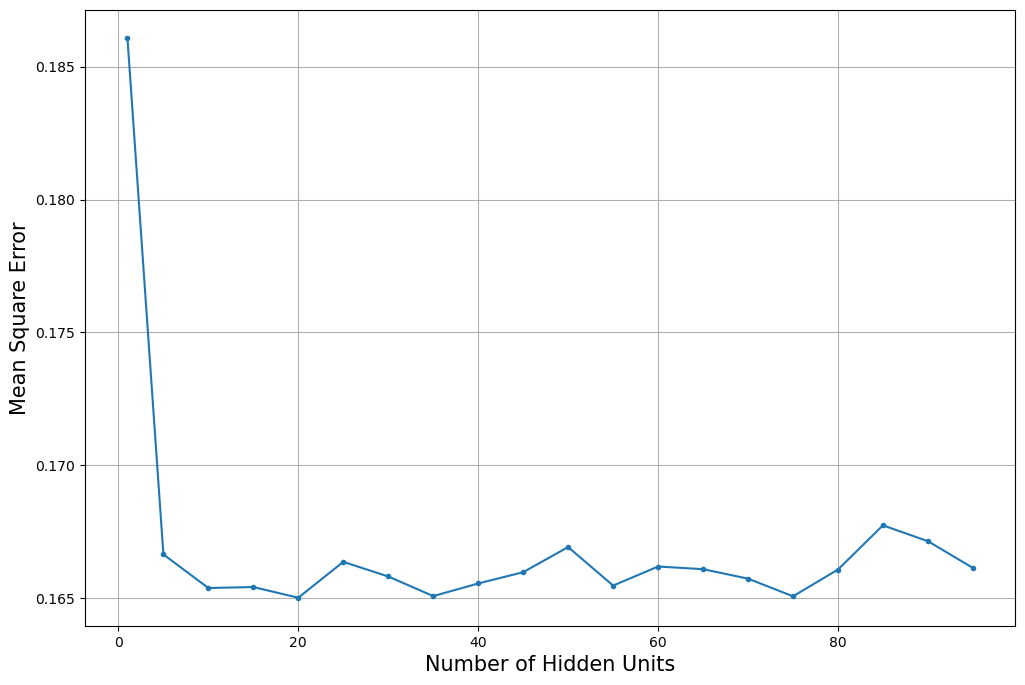

In [ ]:
from matplotlib.pylab import (figure, semilogx, loglog, xlabel, ylabel, legend,
                           title, subplot, show, grid, plot)
import numpy as np
from scipy.io import loadmat
import sklearn.linear_model as lm
from sklearn import model_selection
from sklearn.model_selection import train_test_split


figure(figsize=(12,8))

plot(param_grid['hidden_units'], np.mean(test_error,axis=0),'.-') # Don't plot the bias term
xlabel('Number of Hidden Units',fontsize=15)
ylabel('Mean Square Error',fontsize=15)
grid()

In [ ]:
from matplotlib.pyplot import figure, plot, xlabel, ylabel, show
import numpy as np
from sklearn.neighbors import KNeighborsClassifier
from sklearn import model_selection
import sklearn.tree
import scipy.stats
import numpy as np, scipy.stats as st



# perform statistical comparison of the models
# compute z with squared error.
zrlr = Error_test_rlr
znofeature = Error_test_nofeatures
zann = Error_test_ann.squeeze()
# compute confidence interval of model A
alpha = 0.05
CIrlr = st.t.interval(1-alpha, df=len(zrlr)-1, loc=np.mean(zrlr), scale=st.sem(zrlr))  # Confidence interval
CIno = st.t.interval(1-alpha, df=len(znofeature)-1, loc=np.mean(znofeature), scale=st.sem(znofeature))  # Confidence interval
CIann = st.t.interval(1-alpha, df=len(zann)-1, loc=np.mean(zann), scale=st.sem(zann))  # Confidence interval

# Compute confidence interval of z = zA-zB and p-value of Null hypothesis
print("Confidence interval of model ANN ", CIann, "Confidence interval of model linear regression ", CIrlr, "Confidence interval of model no features ", CIno)

z = zrlr - znofeature 
CI = st.t.interval(1-alpha, len(z)-1, loc=np.mean(z), scale=st.sem(z))  # Confidence interval
p = 2*st.t.cdf( -np.abs( np.mean(z) )/st.sem(z), df=len(z)-1)  # p-value
print("Confidnece interval of rlr vs base ", CI, ' p-value ', p)
z = zann - znofeature
CI = st.t.interval(1-alpha, len(z)-1, loc=np.mean(z), scale=st.sem(z))  # Confidence interval
p = 2*st.t.cdf( -np.abs( np.mean(z) )/st.sem(z), df=len(z)-1)  # p-value
print("Confidnece interval of ann vs base ", CI, ' p-value ', p)
z = zann - zrlr
print(z)
CI = st.t.interval(1-alpha, len(z)-1, loc=np.mean(z), scale=st.sem(z))  # Confidence interval
p = 2*st.t.cdf( -np.abs( np.mean(z) )/st.sem(z), df=len(z)-1)  # p-value
print("Confidnece interval of rlr vs ann ", CI, ' p-value ', p)

Confidence interval of model ANN  (0.16278440006468978, 0.16541559993531021) Confidence interval of model linear regression  (0.17086591399229692, 0.17411408600770303) Confidence interval of model no features  (0.2499498379044968, 0.2500101620955032)
Confidnece interval of rlr vs base  (-0.07911268499727801, -0.07586731500272202)  p-value  2.5333386131334274e-15
Confidnece interval of ann vs base  (-0.08719508119969094, -0.08456491880030906)  p-value  1.5169739413230234e-16
[-0.0099 -0.0085 -0.0087 -0.0082 -0.0089 -0.0058 -0.007  -0.0104 -0.008
 -0.0085]
Confidnece interval of rlr vs ann  (-0.009329665462009484, -0.007450334537990516)  p-value  8.323258158278991e-09
